In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install --quiet cornac==1.5.2 adjustText

In [ ]:
import os
import sys
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
%matplotlib inline

import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.data import Reader
from cornac.eval_methods import RatioSplit
from cornac.models import MostPop, MF, BPR, WMF

%tensorflow_version 1.x
import tensorflow as tf

from tqdm import tqdm

from zipfile import ZipFile
from google.colab import files

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

%cd /content/drive/My Drive/Colab Notebooks/RS_Project

TensorFlow 1.x selected.
System version: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
Cornac version: 1.5.2
Tensorflow version: 1.15.2
/content/drive/My Drive/Colab Notebooks/RS_Project


## Investigating the dataset

In [ ]:
df = pd.read_csv('rating.csv')
n_users = df.user_id.nunique()
n_items = df.anime_id.nunique()
n_ratings = len(df)
rating_matrix_size = n_users * n_items
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Number of available ratings: {n_ratings}")
print(f"Number of all possible ratings: {rating_matrix_size}")
print("-" * 40)
print(f"SPARSITY: {sparsity * 100.0:.2f}%")

Number of users: 69528
Number of items: 8821
Number of available ratings: 6264920
Number of all possible ratings: 613306488
----------------------------------------
SPARSITY: 98.98%


In [ ]:
item_rate_count = df.groupby("anime_id")["user_id"].nunique().sort_values(ascending=False)
item_rate_count.head(5)

anime_id
1535     34226
11757    26309
16498    25289
1575     24125
6547     23565
Name: user_id, dtype: int64

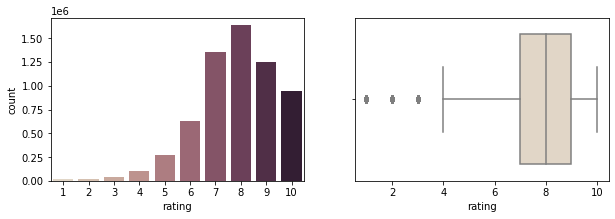

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
sns.countplot(x="rating", data=df, palette="ch:.25", ax=axes[0])
sns.boxplot(x="rating", data=df, palette="ch:.25", ax=axes[1]);

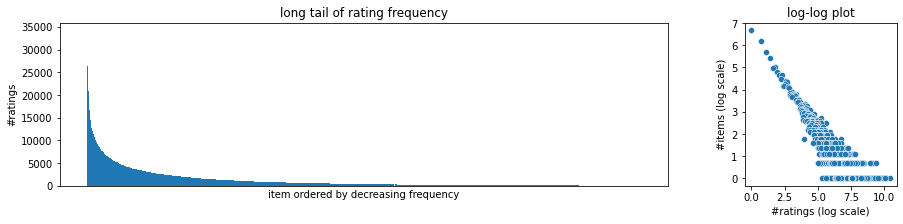

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3),gridspec_kw={'width_ratios': [4, 1]})
axes[0].bar(x=list(map(str,item_rate_count.index))[:5000], height=item_rate_count.values[:5000], width=1.0, align="edge")
axes[0].set_xticks([])
axes[0].set(title="long tail of rating frequency", 
            xlabel="item ordered by decreasing frequency", 
            ylabel="#ratings")

count = item_rate_count.value_counts()
sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
axes[1].set(title="log-log plot", xlabel="#ratings (log scale)", ylabel="#items (log scale)");

## Experimenting different model

In [ ]:
reader = Reader()
data = reader.read('rating.csv', sep=',', skip_lines=1)


eval_method = RatioSplit(
    data,
    test_size=0.2,
    rating_threshold=5.0,
    exclude_unknowns=True,
    verbose=True
)

eval_metrics = [cornac.metrics.NCRR(k=[20]),
                cornac.metrics.NDCG(k=[20]),
                cornac.metrics.Recall(k=20)]

rating_threshold = 5.0
exclude_unknowns = True
---
Training data:
Number of users = 68742
Number of items = 8610
Number of ratings = 5011936
Max rating = 10.0
Min rating = 1.0
Global mean = 7.8
---
Test data:
Number of users = 61506
Number of items = 7324
Number of ratings = 1251813
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 68742
Total items = 8610


In [ ]:
model_lst = []
model_lst.append(MostPop())
model_lst.append(MF(k=50, max_iter=20, learning_rate=0.01, lambda_reg=0.0, use_bias=False, name=f"MF"))
model_lst.append(WMF(k=50, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01, name=f"WMF"))
model_lst.append(BPR(k=50, max_iter=100, learning_rate=0.01, lambda_reg=0.01, name=f"BPR"))
result = cornac.Experiment(eval_method=eval_method, models = model_lst, metrics=eval_metrics)
result.run()

# Calculate Harmonic Mean
for i in range(len(model_lst)):
  ncrr = result.result[i].metric_avg_results['NCRR@20']
  ndcg = result.result[i].metric_avg_results['NDCG@20']
  recall = result.result[i].metric_avg_results['Recall@20']
  print(result.models[i].name,":",round(3 / (1/ncrr+1/ndcg+1/recall),5))


[MostPop] Training started!

[MostPop] Evaluation started!




[MF] Training started!

[MF] Evaluation started!




[WMF] Training started!



Learning completed!

[WMF] Evaluation started!




[BPR] Training started!

[BPR] Evaluation started!




TEST:
...
        | NCRR@20 | NDCG@20 | Recall@20 | Train (s) | Test (s)
------- + ------- + ------- + --------- + --------- + --------
MostPop |  0.1016 |  0.1115 |    0.1254 |    0.0001 |  70.4276
MF      |  0.0546 |  0.0575 |    0.0632 |   17.0431 | 115.4560
WMF     |  0.1105 |  0.1283 |    0.1577 | 1489.4393 | 120.3933
BPR     |  0.1361 |  0.1536 |    0.1771 |  254.0205 | 113.8629

MostPop : 0.112
MF : 0.05822
WMF : 0.12938
BPR : 0.15381


In [ ]:
# output the results
data = cornac.data.Dataset.from_uir(data)
model = BPR(k=400, max_iter=5000, learning_rate=0.01, lambda_reg=0.1, name=f"BPR(iter=5000)").fit(data)

train_set = model.train_set
uid2raw = {v:k for k,v in train_set.uid_map.items()}
iid2raw = {v:k for k,v in train_set.iid_map.items()}

# Write to txt
with open(f'{model.name}.txt', 'w') as f:
    for uidraw in tqdm(range(1, len(uid2raw)+1, 1)): 
        f.write(' '.join([str(iid2raw[idx]) for idx in model.rank(train_set.uid_map[str(uidraw)])[0][:50]]) + '\n')


# Zip the txt
with ZipFile(f'{model.name}.zip', 'w') as zipf:
  zipf.write(f'{model.name}.txt')

# Delete the txt
os.remove(f'{model.name}.txt')

# Download the zip
files.download(f'{model.name}.zip')